# Task: Hospital Admission Automation

The goal of this task is to predict the outcome of an encounter based on the patient's data. Thus, it is a multi-class classification problem as the output is categorical and must belong to the following categories - 

## Necessary imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
import seaborn as sb

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [ ]:
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
! pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 8.5 MB/s eta 0:00:00


## COVID-19 patients

### Data Preparation

In [ ]:
# Loading the main dataframe created in the EDA stage - contains the patient information and 5 medical parameters
main_df = pd.read_csv('main_5_df')

In [ ]:
main_df.head()

,Unnamed: 0,DATE,PATIENT_x,ENCOUNTER,Body Weight,Diastolic Blood Pressure,Heart rate,Respiratory rate,Systolic Blood Pressure,START,...,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,REASONCODE,REASONDESCRIPTION
0,0,2020-01-18,641699c3-03c0-40fc-9f14-38247e0a8cfa,43406fdf-5550-40fe-a4b2-f47ad99a555c,67.0,79.0,76.0,35.0,120.0,2020-01-18T20:55:04Z,...,7b23db63-1dcb-38c0-890b-81fc2df959e0,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,inpatient,1505002,Hospital admission for isolation (procedure),129.16,129.16,59.16,840539006.0,COVID-19
1,1,2020-01-19,641699c3-03c0-40fc-9f14-38247e0a8cfa,43406fdf-5550-40fe-a4b2-f47ad99a555c,67.0,79.0,189.0,12.0,122.0,2020-01-18T20:55:04Z,...,7b23db63-1dcb-38c0-890b-81fc2df959e0,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,inpatient,1505002,Hospital admission for isolation (procedure),129.16,129.16,59.16,840539006.0,COVID-19
2,2,2020-01-20,641699c3-03c0-40fc-9f14-38247e0a8cfa,43406fdf-5550-40fe-a4b2-f47ad99a555c,67.0,74.0,184.0,20.0,126.0,2020-01-18T20:55:04Z,...,7b23db63-1dcb-38c0-890b-81fc2df959e0,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,inpatient,1505002,Hospital admission for isolation (procedure),129.16,129.16,59.16,840539006.0,COVID-19
3,3,2020-01-21,641699c3-03c0-40fc-9f14-38247e0a8cfa,43406fdf-5550-40fe-a4b2-f47ad99a555c,67.0,76.0,113.0,30.0,125.0,2020-01-18T20:55:04Z,...,7b23db63-1dcb-38c0-890b-81fc2df959e0,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,inpatient,1505002,Hospital admission for isolation (procedure),129.16,129.16,59.16,840539006.0,COVID-19
4,4,2020-01-22,641699c3-03c0-40fc-9f14-38247e0a8cfa,43406fdf-5550-40fe-a4b2-f47ad99a555c,67.0,71.0,58.0,35.0,124.0,2020-01-18T20:55:04Z,...,7b23db63-1dcb-38c0-890b-81fc2df959e0,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,inpatient,1505002,Hospital admission for isolation (procedure),129.16,129.16,59.16,840539006.0,COVID-19


In [ ]:
# Taking a look at the shape and datatypes of the columns in the dataset
print("The shape of the main dataset is: ", main_df.shape)
main_df.dtypes

The shape of the main dataset is:  (210544, 22)


Unnamed: 0                    int64
DATE                         object
PATIENT_x                    object
ENCOUNTER                    object
Body Weight                 float64
Diastolic Blood Pressure    float64
Heart rate                  float64
Respiratory rate            float64
Systolic Blood Pressure     float64
START                        object
STOP                         object
ORGANIZATION                 object
PROVIDER                     object
PAYER                        object
ENCOUNTERCLASS               object
CODE                          int64
DESCRIPTION                  object
BASE_ENCOUNTER_COST         float64
TOTAL_CLAIM_COST            float64
PAYER_COVERAGE              float64
REASONCODE                  float64
REASONDESCRIPTION            object
dtype: object

In [ ]:
# Dropping the duplicates
main_df = main_df.drop_duplicates()
print("The shape of the main dataset after dropping duplicates is: ", main_df.shape)

The shape of the main dataset after dropping duplicates is:  (210544, 22)


In [ ]:
# Dropping the irrelevant columns - Unnamed: 0, START and STOP
main_df = main_df.drop(columns=['Unnamed: 0', 'START', 'STOP'])

In [ ]:
# Understanding the unique values in columns
print(set(main_df['ENCOUNTERCLASS']), set(main_df['REASONDESCRIPTION']), set(main_df['REASONCODE']), set(main_df['CODE']), set(main_df['BASE_ENCOUNTER_COST']), set(main_df['TOTAL_CLAIM_COST']), set(main_df['PAYER_COVERAGE']))

{'inpatient'} {'COVID-19'} {840539006.0} {76464004, 1505002, 305351004} {129.16} {129.16} {64.16, 0.0, 69.16, 49.16, 54.16, 89.16, 59.16, 29.16}


From the above code, we can see that the columns ENCOUNTERCLASS, REASONDESCRIPTION, REASONCODE, BASE_ENCOUNTER_COST AND TOTAL_CLAIM_COST are the same for all individuals. The reason for the first two columns being same is that we only selected data related to COVID-19 from the original encounters_df dataset. Therefore, we can remove them from our dataset in this case. However BASE_ENCOUNTER_COST AND TOTAL_CLAIM_COST may have different values for each patient in other datasets and therefore may be significant to modeling in that case.

In [ ]:
# Dropping the columns REASONDESCRIPTION, REASONCODE, BASE_ENCOUNTER_COST AND TOTAL_CLAIM_COST
main_df = main_df.drop(columns = ['ENCOUNTERCLASS', 'REASONDESCRIPTION', 'REASONCODE', 'BASE_ENCOUNTER_COST', 'TOTAL_CLAIM_COST'])
main_df.head()

,DATE,PATIENT_x,ENCOUNTER,Body Weight,Diastolic Blood Pressure,Heart rate,Respiratory rate,Systolic Blood Pressure,ORGANIZATION,PROVIDER,PAYER,CODE,DESCRIPTION,PAYER_COVERAGE
0,2020-01-18,641699c3-03c0-40fc-9f14-38247e0a8cfa,43406fdf-5550-40fe-a4b2-f47ad99a555c,67.0,79.0,76.0,35.0,120.0,3bd5eda0-16da-3ba5-8500-4dfd6ae118b8,7b23db63-1dcb-38c0-890b-81fc2df959e0,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,1505002,Hospital admission for isolation (procedure),59.16
1,2020-01-19,641699c3-03c0-40fc-9f14-38247e0a8cfa,43406fdf-5550-40fe-a4b2-f47ad99a555c,67.0,79.0,189.0,12.0,122.0,3bd5eda0-16da-3ba5-8500-4dfd6ae118b8,7b23db63-1dcb-38c0-890b-81fc2df959e0,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,1505002,Hospital admission for isolation (procedure),59.16
2,2020-01-20,641699c3-03c0-40fc-9f14-38247e0a8cfa,43406fdf-5550-40fe-a4b2-f47ad99a555c,67.0,74.0,184.0,20.0,126.0,3bd5eda0-16da-3ba5-8500-4dfd6ae118b8,7b23db63-1dcb-38c0-890b-81fc2df959e0,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,1505002,Hospital admission for isolation (procedure),59.16
3,2020-01-21,641699c3-03c0-40fc-9f14-38247e0a8cfa,43406fdf-5550-40fe-a4b2-f47ad99a555c,67.0,76.0,113.0,30.0,125.0,3bd5eda0-16da-3ba5-8500-4dfd6ae118b8,7b23db63-1dcb-38c0-890b-81fc2df959e0,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,1505002,Hospital admission for isolation (procedure),59.16
4,2020-01-22,641699c3-03c0-40fc-9f14-38247e0a8cfa,43406fdf-5550-40fe-a4b2-f47ad99a555c,67.0,71.0,58.0,35.0,124.0,3bd5eda0-16da-3ba5-8500-4dfd6ae118b8,7b23db63-1dcb-38c0-890b-81fc2df959e0,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,1505002,Hospital admission for isolation (procedure),59.16


The columns DATE, ENCOUNTER do not contribute to the target variable. So, we can drop them

In [ ]:
main_df = main_df.drop(columns = ['DATE','ENCOUNTER'])

Let's visualize the other categorical columns -  ORGANIZATION, PROVIDER, PAYER. 

In [ ]:
len(list(set(main_df['ORGANIZATION'])))

91

In [ ]:
len(list(set(main_df['PROVIDER'])))

91

In [ ]:
list(set(main_df['PAYER']))

['7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a',
 '047f6ec3-6215-35eb-9608-f9dda363a44c',
 '6e2f1a2d-27bd-3701-8d08-dae202c58632',
 '7caa7254-5050-3b5e-9eae-bd5ea30e809c',
 'b1c428d6-4f07-31e0-90f0-68ffa6ff8c76',
 '4d71f845-a6a9-3c39-b242-14d25ef86a8d',
 'd47b3510-2895-3b70-9897-342d681c769d',
 'b3221cfc-24fb-339e-823d-bc4136cbc4ed',
 '5059a55e-5d6e-34d1-b6cb-d83d16e57bcf']

In [ ]:
main_df['DESCRIPTION'].value_counts()

Hospital admission for isolation (procedure)       186861
Admission to intensive care unit (procedure)        23659
Hospital admission  for observation (procedure)        24
Name: DESCRIPTION, dtype: int64

[Text(0, 0, 'Hospital admission for isolation (procedure)'),
 Text(1, 0, 'Admission to intensive care unit (procedure)'),
 Text(2, 0, 'Hospital admission  for observation (procedure)')]

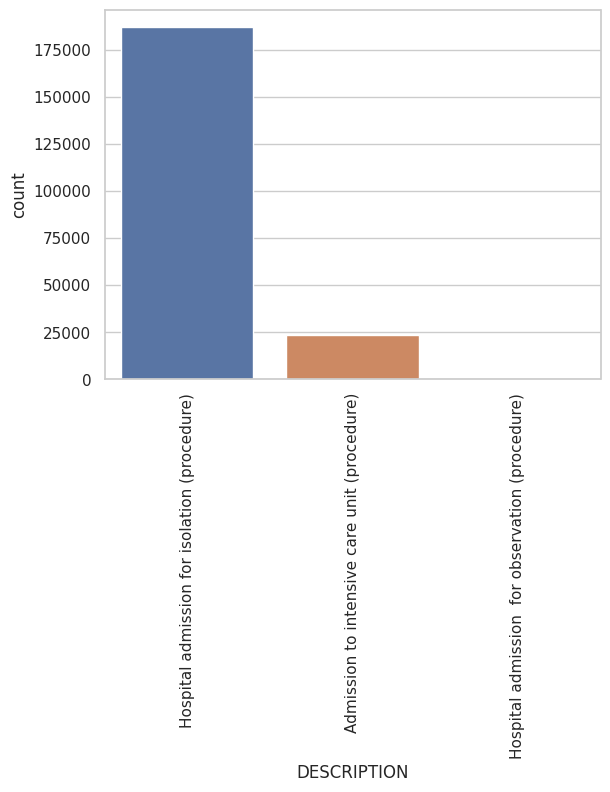

In [ ]:
g = sns.countplot(x=main_df['DESCRIPTION'])
g.set_xticklabels(
    labels= list(set(main_df['DESCRIPTION'])), rotation=90)

<Axes: ylabel='DESCRIPTION'>

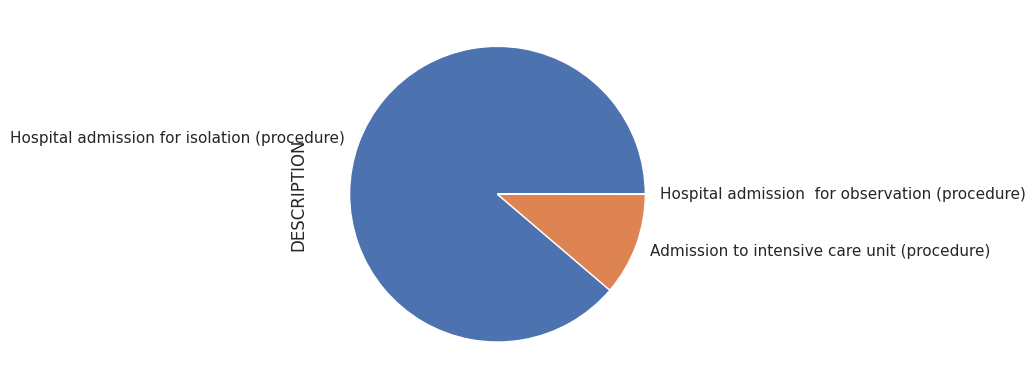

In [ ]:
# Visualizing class imbalance
main_df['DESCRIPTION'].value_counts().plot.pie()

Since ML models require that the columns be numeric, we will perform label encoding of these categorical variables

In [ ]:
le1 = preprocessing.LabelEncoder()
main_df['ORGANIZATION'] = le1.fit_transform(main_df['ORGANIZATION'])

In [ ]:
le2 = preprocessing.LabelEncoder()
main_df['PROVIDER'] = le2.fit_transform(main_df['PROVIDER'])

In [ ]:
le3 = preprocessing.LabelEncoder()
main_df['PAYER'] = le3.fit_transform(main_df['PAYER'])

In [ ]:
le4 = preprocessing.LabelEncoder()
main_df['DESCRIPTION'] = le4.fit_transform(main_df['DESCRIPTION'])

In [ ]:
main_df.dtypes

PATIENT_x                    object
Body Weight                 float64
Diastolic Blood Pressure    float64
Heart rate                  float64
Respiratory rate            float64
Systolic Blood Pressure     float64
ORGANIZATION                  int64
PROVIDER                      int64
PAYER                         int64
CODE                          int64
DESCRIPTION                   int64
PAYER_COVERAGE              float64
dtype: object

In [ ]:
main_df.isna().sum()

PATIENT_x                   0
Body Weight                 0
Diastolic Blood Pressure    0
Heart rate                  0
Respiratory rate            0
Systolic Blood Pressure     0
ORGANIZATION                0
PROVIDER                    0
PAYER                       0
CODE                        0
DESCRIPTION                 0
PAYER_COVERAGE              0
dtype: int64

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

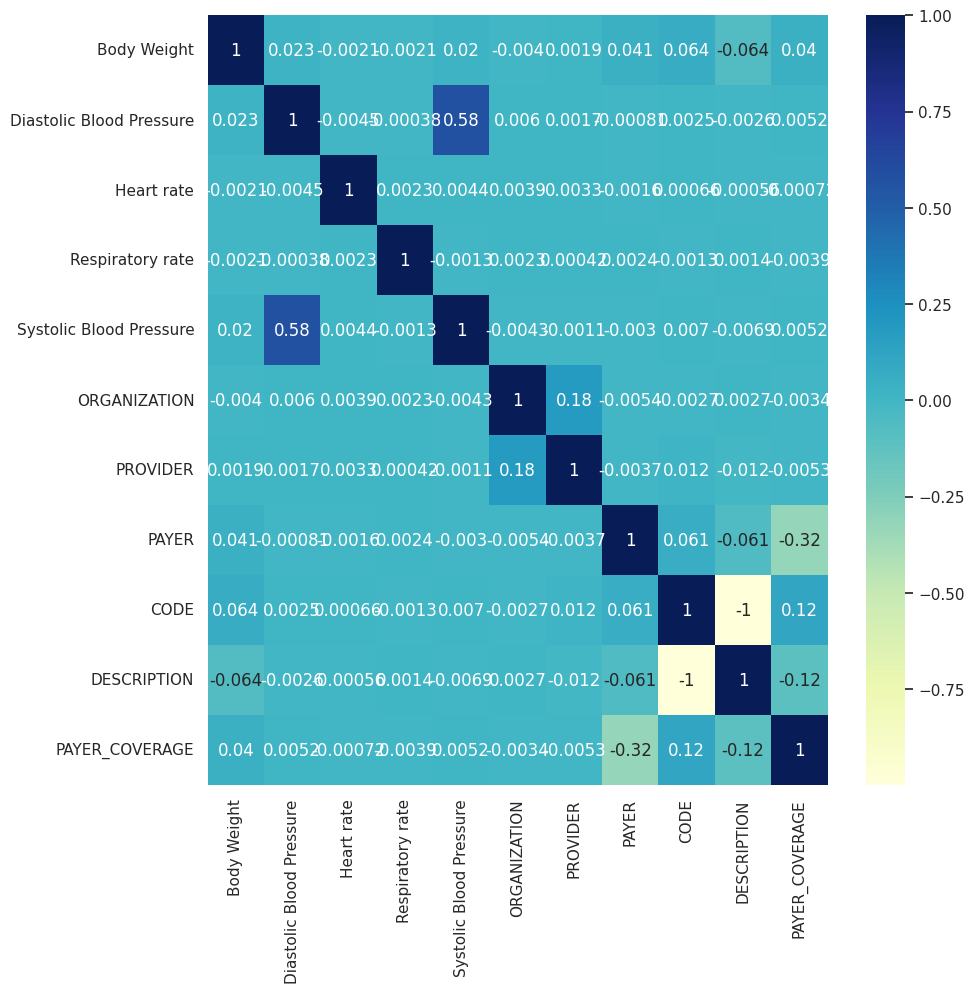

In [ ]:
# Correlation Heatmap
fig, ax = plt.subplots(figsize=(10,10))  
sb.heatmap(main_df.corr(), cmap="YlGnBu", annot=True)

Since we can see that the correlation between CODE and the label DESCRIPTION is -1, it will cause artificially inflated performance values. Therefore, we need to drop the column CODE

In [ ]:
main_df = main_df.drop(columns=['CODE'])

In [ ]:
main_df.to_csv('cleaned_main_df')

### Modeling

In [ ]:
main_df = main_df.drop(columns=['PATIENT_x'])

In [ ]:
# Focusing only on ICU and isolation predictions as we don't have remotely enough data for observation predictions
main_df = main_df.loc[((main_df['DESCRIPTION'] == 0) | (main_df['DESCRIPTION'] == 2))] 

In [ ]:
# Saving the final curated dataset
main_df.to_csv('data2.csv')

In [ ]:
# Creating the X (independent variables) and y (target variable) dataframe
df_X = main_df.loc[:, ~main_df.columns.isin(['DESCRIPTION'])]
df_Y = main_df[['DESCRIPTION']]

As our goal is to automate the process of triaging patients into ICU, isolation or observation as they come to the hospital, we will not be focusing on mortality at this point of time. Therefore, we will not consider tuples corresponding to 'Death Certificate' outcome.

In [ ]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=42) 

In [ ]:
# y_train = np.asarray(y_train).reshape(-1)
# y_test = np.asarray(y_test).reshape(-1)

In [ ]:
# X_train = np.asarray(X_train)
# X_test = np.asarray(X_test)

In [ ]:
# print("X_train.shape: ", X_train.shape)
# print("y_train.shape: ", y_train.shape)
# print("X_test.shape: ", X_test.shape)
# print("y_test.shape: ", y_test.shape)

In [ ]:
# Standard scaling
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

#### Random Forest Classifier

In [ ]:
# Training the Random Forest Classifer
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_std,y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(random_state=42)

In [ ]:
# Prediction
ran_test_preds = clf.predict(X_test_std)

In [ ]:
# Classification Report
print(metrics.classification_report(y_test, ran_test_preds))

              precision    recall  f1-score   support

           0       0.59      0.06      0.12      4691
           2       0.89      0.99      0.94     37413

    accuracy                           0.89     42104
   macro avg       0.74      0.53      0.53     42104
weighted avg       0.86      0.89      0.85     42104



In [ ]:
# AUC
print("The ROC-AUC score of Random Forest model = ", roc_auc_score(y_test, ran_test_preds, multi_class ='ovo', average='macro'))

The ROC-AUC score of Random Forest model =  0.5291432123378935


In [ ]:
# Cohen Kappa Score
cohen_kappa_score(y_test, ran_test_preds)

0.09561685632729167

The model is doing poorly on class 0. We can attempt to fix class imbalance with SMOTE - Synthetic Minority Oversampling Technique

In [ ]:
# Fixing class imbalance with SMOTE - Synthetic Minority Oversampling Technique
smote_over = SMOTE()
X_train_smote, y_train_smote = smote_over.fit_resample(X_train_std, y_train)

In [ ]:
# Training the Random Forest Classifer
smote_clf = RandomForestClassifier(random_state=42)
smote_clf.fit(X_train_smote,y_train_smote)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(random_state=42)

In [ ]:
# Prediction
smote_preds = smote_clf.predict(X_test_std)

In [ ]:
# Classification Report
print(metrics.classification_report(y_test, smote_preds))

              precision    recall  f1-score   support

           0       0.48      0.15      0.23      4691
           2       0.90      0.98      0.94     37413

    accuracy                           0.89     42104
   macro avg       0.69      0.57      0.59     42104
weighted avg       0.85      0.89      0.86     42104



In [ ]:
# AUC
print("The ROC-AUC score of Random Forest model with oversampling = ", roc_auc_score(y_test, smote_preds, multi_class ='ovo', average='macro'))

The ROC-AUC score of Random Forest model with oversampling =  0.566650985007024


In [ ]:
# Cohen Kappa Score
cohen_kappa_score(y_test, smote_preds)

0.18924436886883111

#### Penalized SVM

In [ ]:
svc = SVC(class_weight='balanced', probability=True)

In [ ]:
# Training the penalized support vector classifier
svc.fit(X_train_std, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Prediction
svc_preds = svc.predict(X_test_std)

In [ ]:
# Classification Report
print(metrics.classification_report(y_test, svc_preds))

In [ ]:
# AUC
print("The ROC-AUC score of Penalized SVM model with oversampling = ", roc_auc_score(y_test, svc_preds, multi_class ='ovo', average='macro'))

In [ ]:
# Cohen Kappa Score
cohen_kappa_score(y_test, svc_preds)

#### Gradient Boosting Classifier

In [ ]:
# Training the Random Forest Classifer
clf = GradientBoostingClassifier(random_state=42)
clf = clf.fit(X_train_smote,y_train_smote)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [ ]:
# Prediction
gb_test_preds = clf.predict(X_test_std)

In [ ]:
# Classification Report
print(metrics.classification_report(y_test, gb_test_preds))

              precision    recall  f1-score   support

           0       0.22      0.36      0.27      4691
           2       0.91      0.83      0.87     37413

    accuracy                           0.78     42104
   macro avg       0.56      0.60      0.57     42104
weighted avg       0.84      0.78      0.81     42104



In [ ]:
# AUC
print("The ROC-AUC score of Gradient Boosting model with oversampling = ", roc_auc_score(y_test, gb_test_preds, multi_class ='ovo', average='macro'))

The ROC-AUC score of Gradient Boosting model with oversampling =  0.5992723497965291


In [ ]:
# Cohen Kappa Score
cohen_kappa_score(y_test, gb_test_preds)

0.152903210136911

Even with oversampling, we can observe that due to the severe class imbalance, upsampling is leading to data fabrication and thus the model does not perform well on unseen data. Even if the task is converted to a binary classification problem (patient admitted for isolation / not), the total data for non-isolation patients is very very less as compared to the data for isolation patients

To improve the performance of this task, more data should be collected for different admission outcomes

#### Feature Importance

In [ ]:
# Based on Cohen Kappa Score
best_clf = smote_clf

Text(0.5, 1.0, 'Feature Importance')

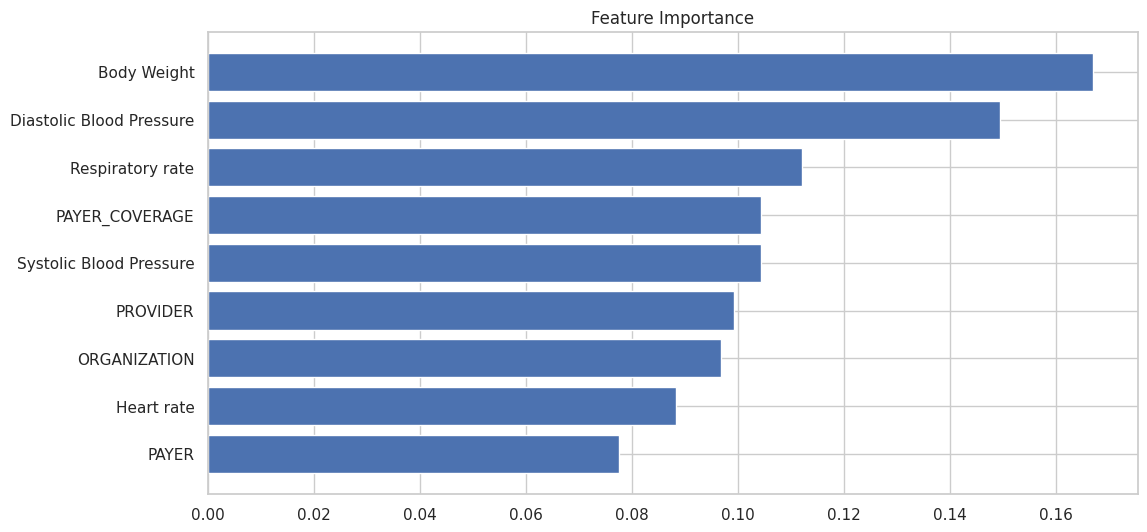

In [ ]:
# Feature Importance graph
feature_importance = best_clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

#### SHAP Explainability values

In [ ]:
explainer = shap.Explainer(best_clf)
shap_values = explainer(X_test_std)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center', color='red')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('SHAP Importance')